# **AutoEncoders & Variational AutoEncoders**

<img src="https://pureai.com/articles/2020/05/07/~/media/ecg/pureai/images/2020/05/autoencoders3.asxh" width=70%>


## Chapter 1. AutoEncoders

The idea of AutoEncoder is really simple.<br>
We get data, pass it through encoder (stack of layers) to map it to lower dimension.<br>
Then from this lower dimension we reconstruct the passed data using MSE to compare them and measure quality.<br>
Sounds great, sounds good!<br>
AutoEncoder can be visualized as follows:<br>

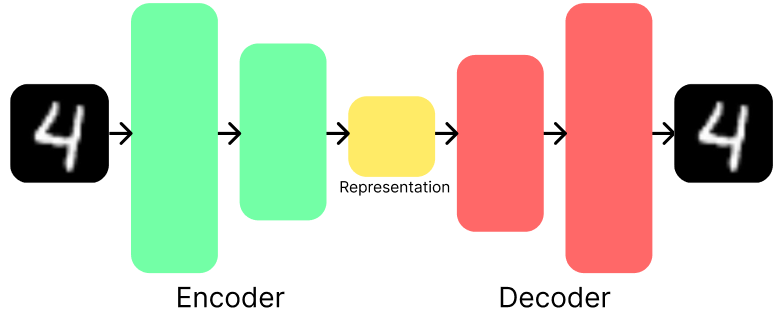

<br>

Finally, for image generation we pass random coordinates in this learned space and recreate image from coordinates.<br>
In training process AutoEncoder is learning how to organise data and how to decode from there.<br>
Let's implement autoencoder on MNIST dataset using both Linear layers and Convolutional layers!

In [1]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Load the data

data = MNIST(root="./data", train=True, transform=transforms.ToTensor(), download=True)
data

100%|██████████| 9.91M/9.91M [00:00<00:00, 15.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.57MB/s]


Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
dataloader = DataLoader(data, batch_size=16, shuffle=True, pin_memory=True)
dataloader

### Let's start with a simple Feed-Forward nets

In [5]:
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Linear(784, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 32)
    )

  def forward(self, input):
    return self.encoder(input)

In [6]:
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.decoder = nn.Sequential(
        nn.Linear(32, 64),
        nn.ReLU(),
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, 784),
        nn.Sigmoid()
    )

  def forward(self, input):
    return self.decoder(input)

In [7]:
class AutoEncoder(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, input):
    encoder_out = self.encoder(input)
    decoder_out = self.decoder(encoder_out)
    return decoder_out

In [8]:
# Training Loop!

epochs = 5

encoder = Encoder().to(device)
decoder = Decoder().to(device)
autoencoder = AutoEncoder(encoder, decoder).to(device)

lr = 0.001

loss_fn = nn.MSELoss()
optimizer = optim.RMSprop(autoencoder.parameters(), lr=lr)

Epoch: 1 | 149.57228088378906


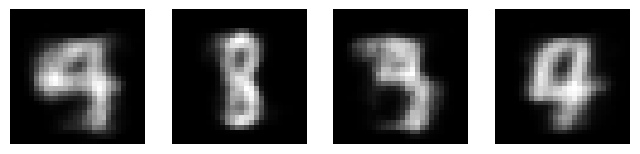

Epoch: 2 | 106.35700225830078


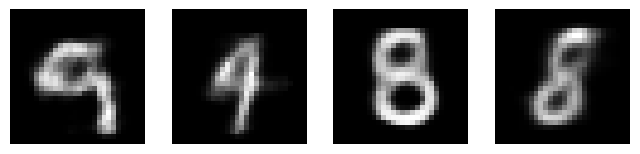

Epoch: 3 | 89.91422271728516


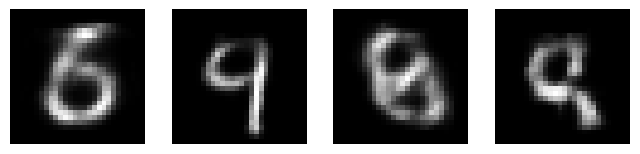

Epoch: 4 | 78.40763854980469


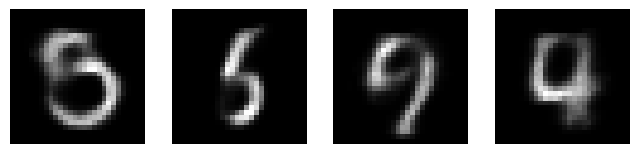

Epoch: 5 | 72.21192169189453


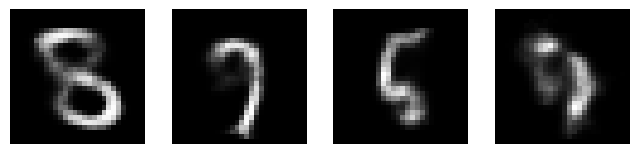

In [9]:
for epoch in range(epochs):
  autoencoder.train()
  epoch_loss = 0
  for img, _ in dataloader:
    img = img.to(device)
    img = img.view(-1, 1, 784)  # Flatten
    reconstruction = autoencoder(img)
    batch_loss = loss_fn(reconstruction, img)
    epoch_loss += batch_loss

    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()

  print(f"Epoch: {epoch + 1} | {epoch_loss.item()}")

  # Generate Images from noise
  autoencoder.eval()
  with torch.inference_mode():
    random_ = torch.randn(4, 1, 32, device=device)
    reconstruction = decoder(random_).cpu().view(4, 28, 28, 1)
    plt.figure(figsize=(8, 4))
    for n, img in enumerate(reconstruction):
      plt.subplot(1, 4, n+1)
      plt.axis("off")
      plt.imshow(img, cmap="gray")
    plt.show()

Well...<br>
It's definitely something simmilar to MNIST digits, but it's really messy...<br>
Uhm... Maybe CNNs can Help!

In [10]:
class ConvEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 8, kernel_size=4),  # (B, 8, 25, 25)
        # nn.BatchNorm2d(num_features=8),
        nn.LeakyReLU(0.2),
        nn.Conv2d(8, 16, kernel_size=3),  # (B, 16, 23, 23)
        # nn.BatchNorm2d(num_features=16),
        nn.LeakyReLU(0.2),
        nn.Conv2d(16, 32, kernel_size=3, stride=2),  # (B, 32, 11, 11)
        # nn.BatchNorm2d(num_features=32),
        nn.LeakyReLU(0.2),
        nn.Conv2d(32, 64, kernel_size=3, stride=2),  # (B, 64, 5, 5)
        nn.Flatten(),
        nn.Linear(64 * 5 * 5, 800),
        nn.LeakyReLU(0.2),
        nn.Linear(800, 400),
        nn.LeakyReLU(0.2),
        nn.Linear(400, 100)
    )

  def forward(self, input):
    return self.encoder(input)

In [11]:
class ConvDecoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.decoder = nn.Sequential(
        nn.Linear(100, 400),
        nn.LeakyReLU(0.2),
        nn.Linear(400, 800),
        nn.LeakyReLU(0.2),
        nn.Linear(800, 64 * 5 * 5),  # (B, 1600)
        nn.Unflatten(1, (64, 5, 5)),
        nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2),
        # nn.BatchNorm2d(num_features=32),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2),
        # nn.BatchNorm2d(num_features=16),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(16, 8, kernel_size=3, stride=1),
        # nn.BatchNorm2d(num_features=8),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(8, 1, kernel_size=4, stride=1),
        # nn.BatchNorm2d(num_features=1),
        nn.Sigmoid(),
    )

  def forward(self, input):
    return self.decoder(input)

In [12]:
class ConvAE(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, input):
    enc = self.encoder(input)
    rec = self.decoder(enc)
    return rec

In [13]:
epochs = 5

conv_encoder = ConvEncoder().to(device)
conv_decoder = ConvDecoder().to(device)
conv_autoencoder = ConvAE(conv_encoder, conv_decoder).to(device)

lr = 0.001
optimizer = optim.Adam(conv_autoencoder.parameters(), lr=lr)
loss_fn = nn.BCELoss()

Epoch: 0 | Loss: 519.7763694599271


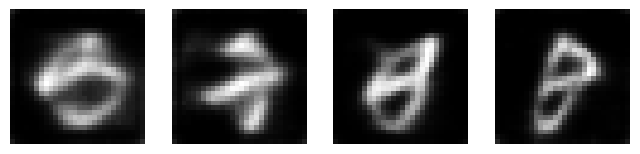

Epoch: 1 | Loss: 331.95804380625486


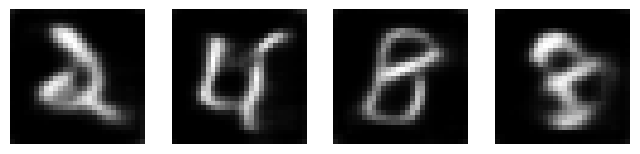

Epoch: 2 | Loss: 307.8115585036576


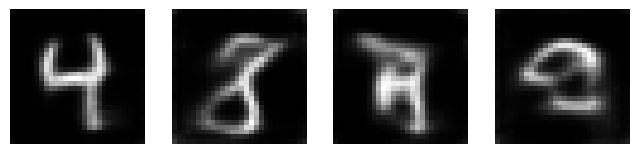

Epoch: 3 | Loss: 296.3953716829419


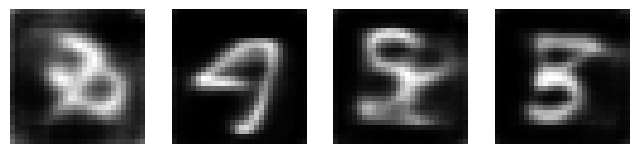

Epoch: 4 | Loss: 288.5997652411461


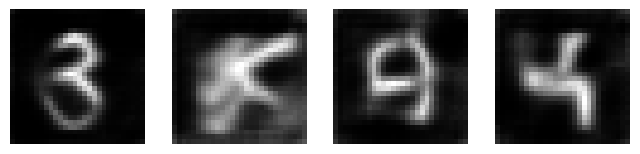

In [14]:
for epoch in range(epochs):
  conv_autoencoder.train()
  epoch_loss = 0
  for img_batch, _ in dataloader:
    img_batch = img_batch.to(device)
    reconstruction = conv_autoencoder(img_batch)
    batch_loss = loss_fn(reconstruction, img_batch)
    epoch_loss += batch_loss.item()

    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()

  print(f"Epoch: {epoch} | Loss: {epoch_loss}")
  conv_autoencoder.eval()
  with torch.inference_mode():
    noise = torch.randn(4, 100).to(device)
    reconstruction = conv_decoder(noise).to("cpu")
    plt.figure(figsize=(8, 4))
    for n, img in enumerate(reconstruction):
      plt.subplot(1, 4, n+1)
      plt.axis("off")
      plt.imshow(img.permute(1, 2, 0).detach().numpy(), cmap="gray")
    plt.show()

Oh... I might have came up with a bad CNN architecture...
Maybe, but let's see a deeper reason for this performance issue.<br>
Let's see how model handles Reconstruction of real images to make sure our CNN components are fine<br>
I definitely came up with a bad CNN architecture, what is quite sad :(

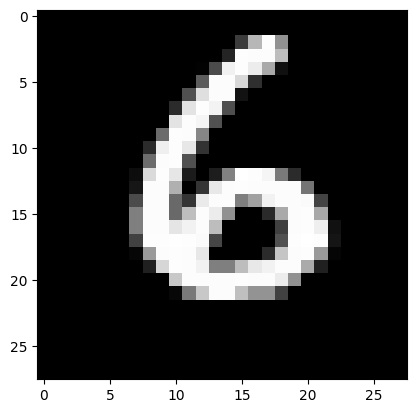

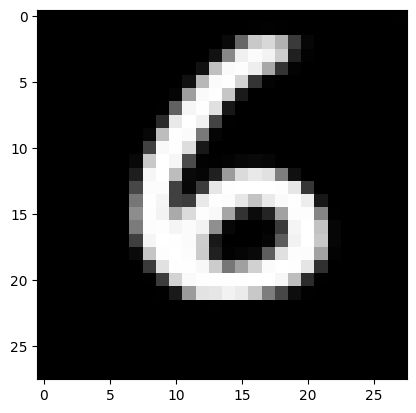

In [29]:
conv_autoencoder.eval()
with torch.inference_mode():
  for img_batch, _ in dataloader:
    img_batch = img_batch.to(device)
    img = img_batch[0].unsqueeze(0)  # (1, 1, 28, 28)
    reconstruction = conv_autoencoder(img).cpu()
    plt.imshow(img.squeeze(0).permute(1, 2, 0).cpu(), cmap="gray")
    plt.show()
    plt.imshow(reconstruction.squeeze(0).permute(1, 2, 0), cmap="gray")
    break

Hmm... Well it appears that our Decoder is perfectly fine.<br>

This means that there's a problem with our input we pass in.<br>
As I mentioned earlier AutoEncoder organizes samples in latent space, but this space is not structured enough, with many gaps.<br>
Selecting coordinate we can randomly land somewhere between 6 and 8 and our decoder will generate mix of 6 and 8 resulting in ugly results.<br>
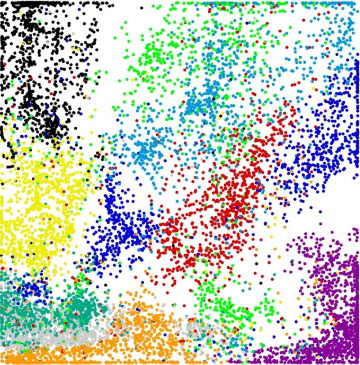


## Chapter 2. Variational AutoEncoders.
Variational AutoEncoders organize space in a better way.<br>
VAE represents latent space as a normal distribution learning mean and variance for it.<br>
This way, it stores only useful information and when sampling from it we'll fall only in meaningful spots.<br>
Point sampling now happens as:<br>
$z = \mu + \sigma \cdot \epsilon$, where $\epsilon$ - random noise vector.<br>
To keep distribution as close to normal as possible we use KL Divergence adding it to reconstruction loss (MSE).<br>

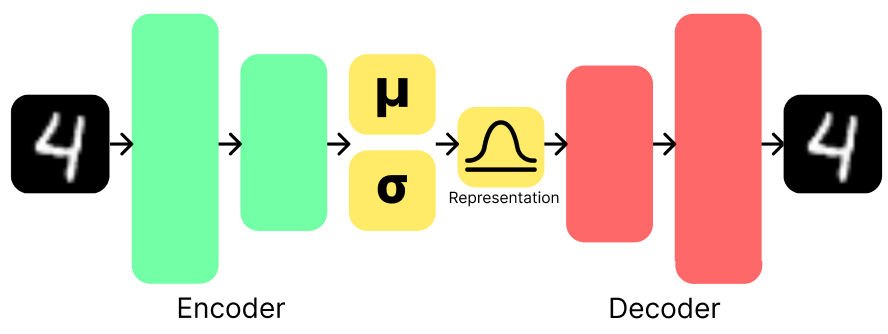

Okay, let's start simple and implement Fully Connected VAE model

In [16]:
class VAEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Linear(784, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
    )
    self.mean = nn.Linear(64, 32)
    self.log_var = nn.Linear(64, 32)

  def forward(self, input):
    enc_ = self.encoder(input)
    mean = self.mean(enc_)
    log_var = self.log_var(enc_)
    return mean, log_var

In [17]:
class VAEDecoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.decoder = nn.Sequential(
        nn.Linear(32, 64),
        nn.ReLU(),
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, 784),
        nn.Sigmoid()
    )

  def forward(self, input):
    return self.decoder(input)

In [18]:
class VAE(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, input):
    mean, log_var = self.encoder(input)
    std = torch.exp(0.5 * log_var)  # Why 1/2 log_var?
    z = mean + std * torch.randn_like(std)
    decoder_out = self.decoder(z)
    return decoder_out, mean, log_var

In [19]:
# Training Loop!

epochs = 5

vae_encoder = VAEncoder().to(device)
vae_decoder = VAEDecoder().to(device)
vae = VAE(vae_encoder, vae_decoder).to(device)

lr = 0.001

loss_fn = nn.MSELoss()
optimizer = optim.Adam(vae.parameters(), lr=lr)

In [20]:
def kl_div(mean, log_var):
  kl_divergence = -0.5 * torch.sum(1 + log_var - mean**2 - log_var.exp())
  return kl_divergence

Epoch: 1 | 222.96585083007812


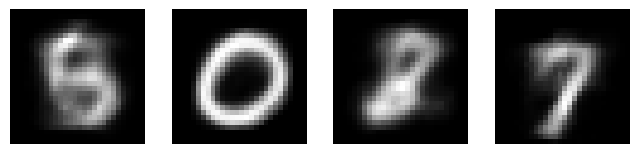

Epoch: 2 | 193.6041717529297


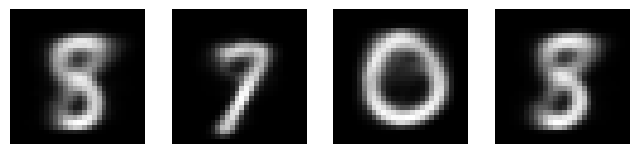

Epoch: 3 | 187.34368896484375


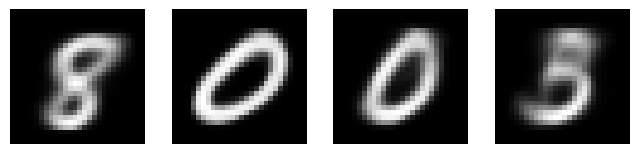

Epoch: 4 | 184.126953125


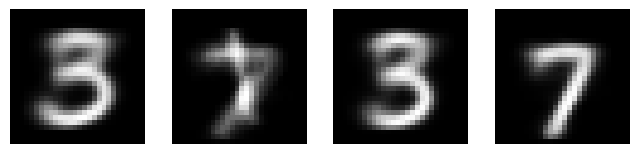

Epoch: 5 | 182.60504150390625


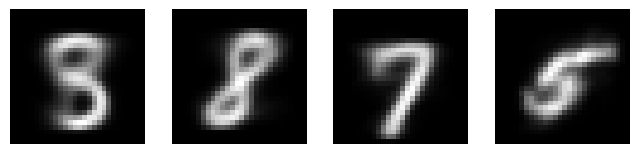

In [21]:
for epoch in range(epochs):
  vae.train()
  epoch_loss = 0
  for img, _ in dataloader:
    img = img.to(device)
    img = img.view(-1, 1, 784)  # Flatten
    reconstruction, mean, log_var = vae(img)
    mse_loss = loss_fn(reconstruction, img)
    kl_loss = kl_div(mean, log_var)
    batch_loss = mse_loss + 0.0001 * kl_loss # Note: scaling kl is extremely important!
    epoch_loss += batch_loss

    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()

  print(f"Epoch: {epoch + 1} | {epoch_loss.item()}")

  # Generate Images from noise
  vae.eval()
  with torch.inference_mode():
    random_ = torch.randn(4, 1, 32, device=device)
    reconstruction = vae_decoder(random_).cpu().view(4, 28, 28, 1)
    plt.figure(figsize=(8, 4))
    for n, img in enumerate(reconstruction):
      plt.subplot(1, 4, n+1)
      plt.axis("off")
      plt.imshow(img, cmap="gray")
    plt.show()

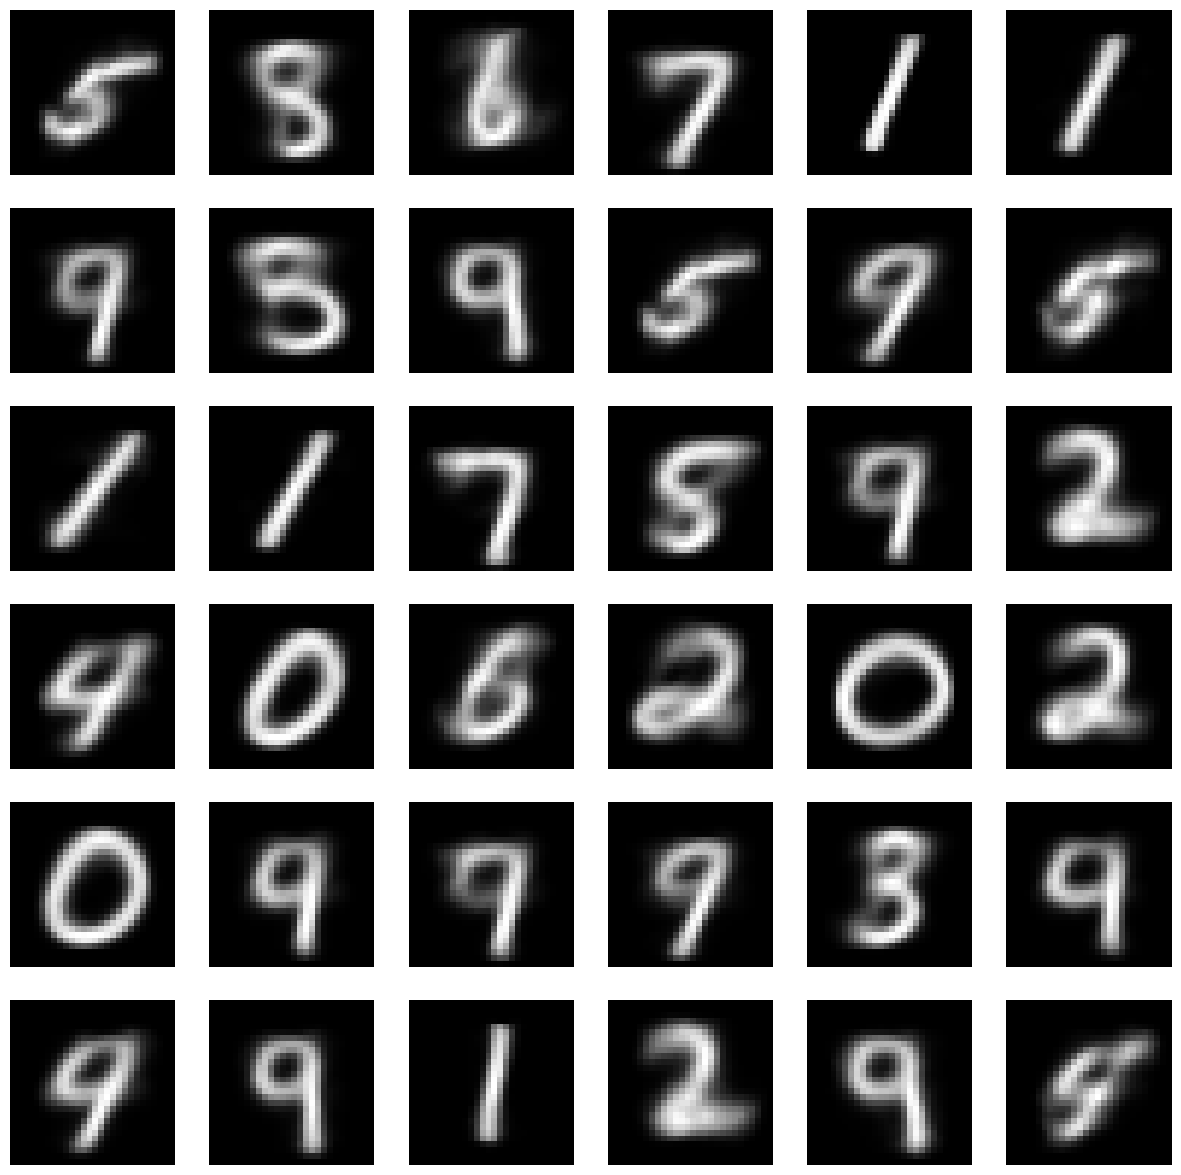

In [22]:
vae.eval()
with torch.inference_mode():
  random_ = torch.randn(36, 1, 32, device=device)
  reconstruction = vae_decoder(random_).cpu().view(36, 28, 28, 1)
  plt.figure(figsize=(15, 15))
  for n, img in enumerate(reconstruction):
    plt.subplot(6, 6, n+1)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
  plt.show()

Yooooo!!! You see this? Look at this look!<br>
We're generating it from random noise, but since our space is now organised, any coordinate gives good results!<br>
Awesome! Let's do CNN<br>

In [23]:
class ConvVAEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 8, kernel_size=4),  # (B, 8, 25, 25)
        # nn.BatchNorm2d(num_features=8),
        nn.LeakyReLU(0.2),
        nn.Conv2d(8, 16, kernel_size=3),  # (B, 16, 23, 23)
        # nn.BatchNorm2d(num_features=16),
        nn.LeakyReLU(0.2),
        nn.Conv2d(16, 32, kernel_size=3, stride=2),  # (B, 32, 11, 11)
        # nn.BatchNorm2d(num_features=32),
        nn.LeakyReLU(0.2),
        nn.Conv2d(32, 64, kernel_size=3, stride=2),  # (B, 64, 5, 5)
        nn.Flatten(),
        nn.Linear(64 * 5 * 5, 800),
        nn.LeakyReLU(0.2),
        nn.Linear(800, 400)
    )
    self.mean = nn.Linear(400, 100)
    self.log_var = nn.Linear(400, 100)

  def forward(self, input):
    enc_ = self.encoder(input)
    mean = self.mean(enc_)
    log_var = self.log_var(enc_)
    return mean, log_var

In [24]:
class ConvVAEDecoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.decoder = nn.Sequential(
        nn.Linear(100, 400),
        nn.LeakyReLU(0.2),
        nn.Linear(400, 800),
        nn.LeakyReLU(0.2),
        nn.Linear(800, 64 * 5 * 5),  # (B, 1600)
        nn.Unflatten(1, (64, 5, 5)),
        nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2),
        # nn.BatchNorm2d(num_features=32),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2),
        # nn.BatchNorm2d(num_features=16),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(16, 8, kernel_size=3, stride=1),
        # nn.BatchNorm2d(num_features=8),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(8, 1, kernel_size=4, stride=1),
        # nn.BatchNorm2d(num_features=1),
        nn.Sigmoid(),
    )

  def forward(self, input):
    return self.decoder(input)

In [25]:
class ConVAE(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, input):
    mean, log_var = self.encoder(input)
    std = torch.exp(0.5 * log_var)
    z = mean + std * torch.randn_like(std)
    rec = self.decoder(z)
    return rec, mean, log_var

In [26]:
epochs = 5

conv_vae_encoder = ConvVAEncoder().to(device)
conv_vae_decoder = ConvVAEDecoder().to(device)
conv_vae = ConVAE(conv_vae_encoder, conv_vae_decoder).to(device)

lr = 0.001
optimizer = optim.Adam(conv_vae.parameters(), lr=lr)
loss_fn = nn.BCELoss()

Epoch: 0 | Loss: 717.755457624793


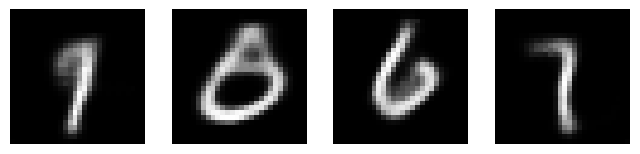

Epoch: 1 | Loss: 569.1151329800487


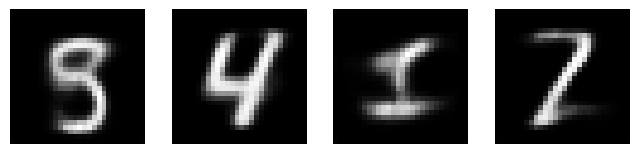

Epoch: 2 | Loss: 545.1214152127504


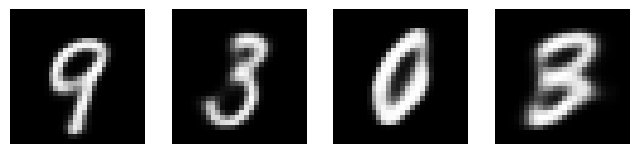

Epoch: 3 | Loss: 534.4036332517862


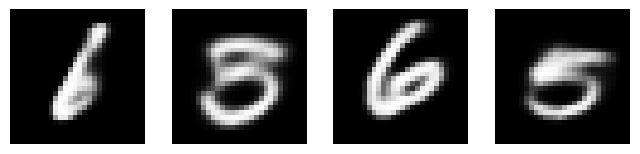

Epoch: 4 | Loss: 526.9894626662135


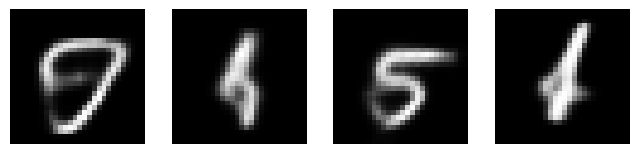

In [27]:
for epoch in range(epochs):
  conv_vae.train()
  epoch_loss = 0
  for img_batch, _ in dataloader:
    img_batch = img_batch.to(device)
    reconstruction, mean, log_var = conv_vae(img_batch)
    bce_loss = loss_fn(reconstruction, img_batch)
    kl_loss = kl_div(mean, log_var)
    batch_loss = bce_loss + 0.0001 * kl_loss
    epoch_loss += batch_loss.item()

    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()

  print(f"Epoch: {epoch} | Loss: {epoch_loss}")
  conv_vae.eval()
  with torch.inference_mode():
    noise = torch.randn(4, 100).to(device)
    reconstruction = conv_vae_decoder(noise).to("cpu")
    plt.figure(figsize=(8, 4))
    for n, img in enumerate(reconstruction):
      plt.subplot(1, 4, n+1)
      plt.axis("off")
      plt.imshow(img.permute(1, 2, 0).detach().numpy(), cmap="gray")
    plt.show()

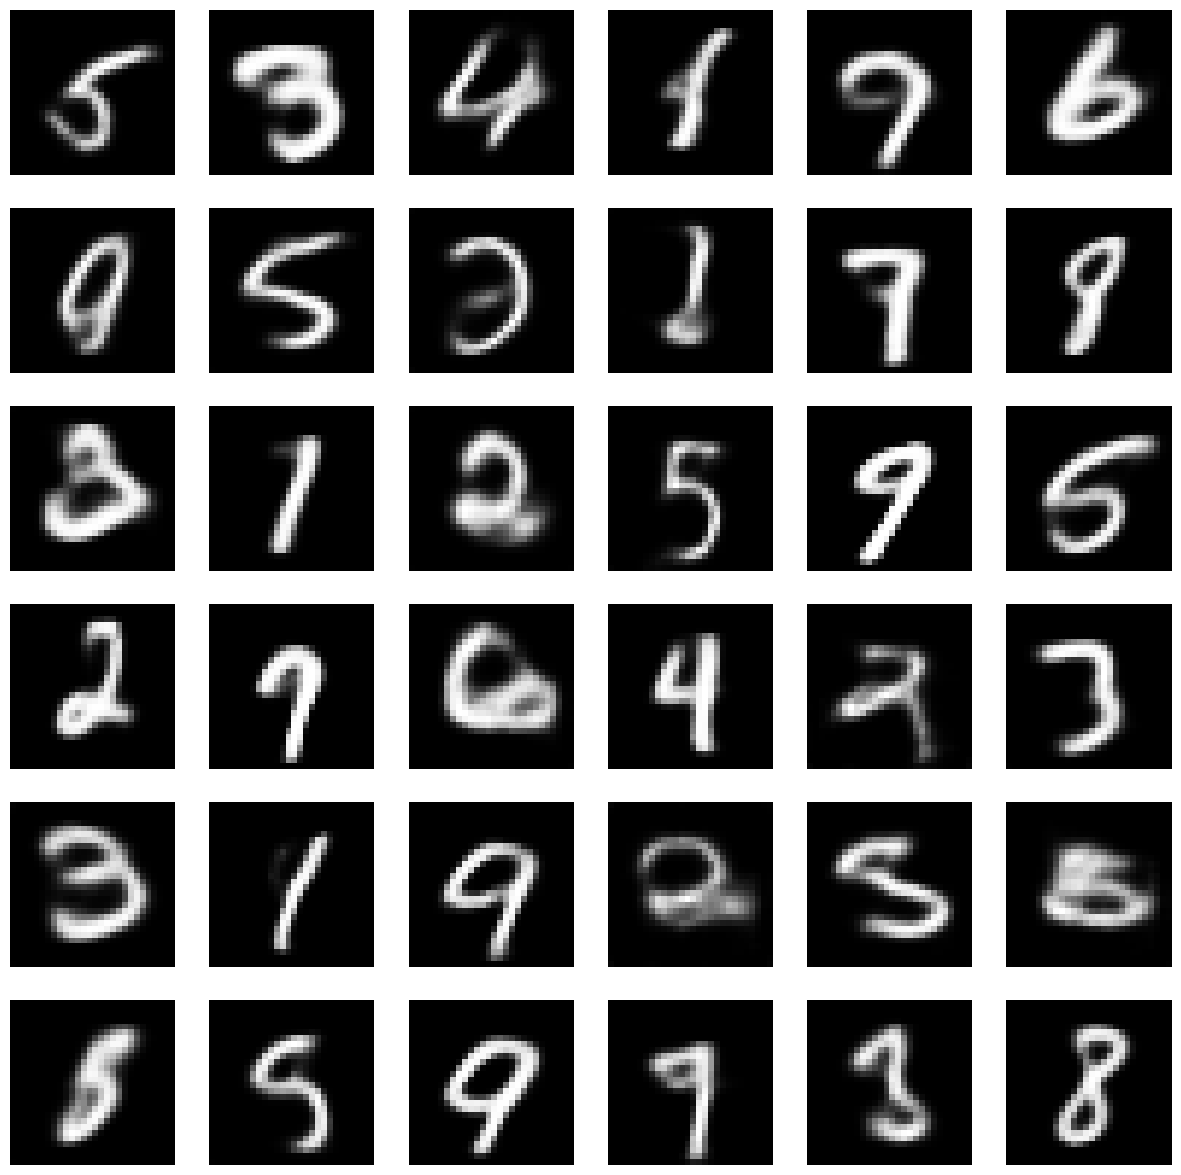

In [28]:
conv_vae.eval()
with torch.inference_mode():
  random_ = torch.randn(36, 100, device=device)
  reconstruction = conv_vae_decoder(random_).cpu()
  plt.figure(figsize=(15, 15))
  for n, img in enumerate(reconstruction):
    plt.subplot(6, 6, n+1)
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0), cmap="gray")
  plt.show()

###  Alright,  CNN gives sharper results, but due to architecture, which in my opinion kinda sucks, results geometrically are worse

# **That's it**
Pretty simple, pretty cool idea.<br>
VAEs are used in different scenarios and for different tasks.<br>
**Not to mention Tuning Latent Vectors**

Here's a visualization of VAE latent space<br>
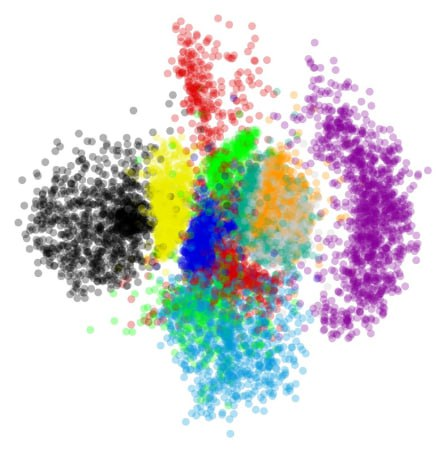